In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr
import scipy.stats as stats


#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well


#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import chi2_distance, ts_visual, time_series_henColumn_tsRow, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)
dico_night_hour = config.dico_night_hour
dico_matching = config.dico_matching
li_binmn = config.li_binmn
penalty = config.penalty
dico_window = config.dico_window
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
print(id_run)

change the configuration file if not done yet!
correctlightschedule_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [5]:
#selected hens
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_selected_hens.pkl'), 'rb'))
len(li_selected_hens)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


132

In [6]:
#daily variables (one row per (henID, date))
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level','FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                              'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 
                              'Nestbox_time_of_first_staid_longer_than900sec',
                              'duration_last-firsttransition_mn'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: int((x-119)/7)+1)
#df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)

#filter by dates
df_daily = df_daily[df_daily['level']<=max_date_adaptability] 
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]

#filter the selected hens
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)] 

#remove days that are not fully recorded
df_daily['nbr_sec_per_day'] = df_daily['level'].map(lambda x: dico_night_hour[correct_key(x,dico_night_hour)]['nbr_hour']*60*60)
df_daily['is_correct_amount_time'] = df_daily.apply(lambda x: x['nbr_sec_per_day']==x['verification_daily_total_duration'], axis=1)
df_daily[(~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull())][['level', 'HenID', 'Total_number_transition', 'dur_values', 'verification_daily_total_duration','nbr_sec_per_day']]
print(df_daily.shape)
display(df_daily = df_daily[~((~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull()))])
print(df_daily.shape)

#remove the days where the night had movement recorded but not the days
print(df_daily.shape)
#display(df_daily[df_daily.isna().any(axis=1)])
df_daily = df_daily[~df_daily['verification_daily_total_duration'].isnull()]
print(df_daily.shape)

df_daily['dur_values_normalized'].replace('[nan, nan, nan, nan, nan]','[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))
df_daily['duration_last-firsttransition_mn'] = df_daily['duration_last-firsttransition_mn'].astype(float)
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27214, 199)
(6772, 199)
(6772, 199)
(6772, 199)
(6429, 199)
(6429, 199)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL,weeks_in_laying_barn
0,hen_1,2020-09-30,0.0,18886.0,3488.0,518.0,5908.0,28800.0,"[0.0, 18886.0, 3488.0, 518.0, 5908.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [7]:
#cleaned data of the tracking system movements
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', 
                 parse_dates=['Timestamp', 'date'], dayfirst=True) 
df = df[df['Timestamp']<=max_date_adaptability+dt.timedelta(days=2)] #add two days to have the next observations as well when doing the 1sec ts
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df = df[df['HenID'].isin(li_selected_hens)] 
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(301289, 17)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
0,hen_71,pen12,10 - 12,3_Zone,1.0,2020-09-29 09:07:00,2020-09-29,2020-09-29 09:08:26.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:07:00
1,hen_7,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:08:12,2020-09-29,2020-09-29 09:12:16.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:08:00
2,hen_10,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:19:19,2020-09-29,2020-09-29 09:20:27.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:19:00


In [8]:
#focal birds info (one row per bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'],
                     dayfirst=True) 
df_FB = df_FB[df_FB['HenID'].isin(li_selected_hens)]
df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
print(df_FB.shape)
df_FB.head(3)

(132, 12)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment,percentage_of_gain_weight
0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,OFH,49.603175
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,OFH,39.093458
3,hen_101,5,MEXP,3.0,2020-06-10,1082.0,66.0,1625.7,1751.1,1723.4,OFH,50.249538


# Compute differences

In [9]:
#intersection of two list
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
lst1 = [15, 9, 10, 56, 23, 78, 5, 4, 9] 
lst2 = [9, 4, 5, 36, 47, 26, 10, 45, 87] 
print(intersection(lst1, lst2)) 

[9, 10, 4, 5]


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#for efficiency purpose let's compute the bined time series first
#note that we will have more entries than needed, as the distrubances days are not removed in the raw-cleaned movements
#dataframe.
dico_bin_zone_level_h = {}   
dmin = dt.datetime(2020,9,30)
dmax = dt.datetime(2020,11,22)

print('computing time series...')
df_ts = time_series_henColumn_tsRow(df[(df['date']<=dmax)&(df['date']>=dmin)&(df['HenID'].isin(li_gr1+li_gr2))], 
                                    config, col_ts='Zone', ts_with_all_hen_value=False, save=False,  hen_time_series=False)

print('Extract binary ts of MLP...')
for nbr_binmn in tqdm.tqdm(li_binmn):
    
    #update results
    dico_bin_zone_level_h[nbr_binmn] = {}

    #reduce to the interval we want
    mi = min(df_ts['Timestamp'].tolist())
    ma = max(df_ts['Timestamp'].tolist())
    #extend the end to the end of the day in case it case the last day available fo the chicken
    Daterange = pd.date_range(start = mi, end = ma, freq = str(nbr_binmn)+'MIN')    
    df_date = pd.DataFrame({str(nbr_binmn)+'mn_timestamp':Daterange})
    new_timestamp = str(nbr_binmn)+'mn_timestamp'
    df_date[new_timestamp] = df_date[new_timestamp].map(lambda x: pd.to_datetime(x))
    df_ts_ = pd.merge_asof(df_ts, df_date, left_on=['Timestamp'], right_on=[new_timestamp], direction='forward')
    #groupby the interval that we want with the number of minutes in nestbox
    li_hen = [v for v in df_ts.columns if 'hen_' in v]
    for ZONE in df['Zone'].unique():

        #update results
        dico_bin_zone_level_h[nbr_binmn][ZONE] = {}

        df_zone_sim = df_ts_.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
        df_zone_sim['date'] = df_zone_sim[new_timestamp].map(lambda x: dt.datetime(x.year,x.month,x.day))

        #groupby date to have a list of zones per day (rows) for the hens (columns)
        df_zone_sim = df_zone_sim.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
        #print(df_zone_sim.shape)
        #display(df_zone_sim.head(3))

        #melt to have one row per (day, hens) to avoid looping to create the dictionary
        df_zone_sim_ = pd.melt(df_zone_sim, id_vars=['date'], value_vars=li_hen)
        #variable column has the henIDs
        #print(df_zone_sim_.shape)
        #display(df_zone_sim_.head(3))
        for d, df__ in df_zone_sim_.groupby(['date']):
            #update results
            dico_bin_zone_level_h[nbr_binmn][ZONE][d] = dict(zip(df__['variable'].tolist(), df__['value'].tolist()))
#save dictionary
pickle.dump(dico_bin_zone_level_h, open(os.path.join(path_extracted_data_visual_adap, 
                                                 id_run+'dico_bin_zone_level_h_SAMEDAYS.pkl'), 'wb'), pickle.HIGHEST_PROTOCOL)

In [10]:
dico_bin_zone_level_h = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 
                                                 id_run+'dico_bin_zone_level_h_SAMEDAYS.pkl'), 'rb'))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#compute the chi2-distance & DTW for each bird with all other birds (because we need this exact same pair to do the visual)
random.seed(rv)
#for efficiency and testing select a subset of animals to be 50 hens, but later we dontn want to restrcit to the pen nor the
#number of animals
nbr_hens = 70
#randomly pick more than one element from the list without repeating elements.
li_selected_hens_rv = random.sample(li_selected_hens, nbr_hens)
li_df = []
li_zone = df['Zone'].unique()
df.sort_values(['Timestamp'], inplace=True)
df_daily_h = df_daily[df_daily['DOA']<=119+30].copy()
li_date = set(df_daily_h['level'].tolist())
df_doa = df_daily[['level','DOA','WOA']].drop_duplicates()
df_doa.head(3)
df_daily_h = df_daily_h[df_daily_h['HenID'].isin(li_selected_hens_rv)].copy()
for d1 in tqdm.tqdm(sorted(list(li_date))):
    doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
    woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
    li_hen_d1 = df_daily_h[df_daily_h['level']==d1]['HenID'].unique()
    #its a symmetric measure, so we only do each combination once
    for i,h1 in enumerate(li_hen_d1):

        #for each hen we want to compute its difference with all other birds 
        for h2 in li_hen_d1[i+1:]:
            
            ############ Overall aviary usage similarity across days
            l1_chi2 = df_daily_h[(df_daily_h['HenID']==h1)&(df_daily_h['level']==d1)]['dur_values_normalized'].values[0]
            l2_chi2 = df_daily_h[(df_daily_h['HenID']==h2)&(df_daily_h['level']==d1)]['dur_values_normalized'].values[0]

            dico_ = {'level':d1, 'level+1':d1, 'henID1':h1, 'henID2':h2, 
                     'dur_values_normalized_henID1':l1_chi2,'dur_values_normalized_henID2':l2_chi2,
                     'chi2distance':chi2_distance(l1_chi2,l2_chi2),'DOA':doa,'WOA':woa}

            ############# Specifics' zones usage similarity across days
            for nbr_binmn in li_binmn:
                for ZONE in li_zone:
                    dtw_value = np.nan
                    try:
                        l1_dtw = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h1], dtype=np.double)
                        l2_dtw = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h2], dtype=np.double)
                        #compute distance measure
                        #psi: #of start and end points of a sequence can be ignored if this would lead to a lower distance
                        dtw_value, paths = dtw.warping_paths(l1_dtw, l2_dtw, window=dico_window[nbr_binmn], psi=0, penalty=penalty) #, max_step=0
                    except Exception as e:
                        print(e)
                        sys.exit()
                        pass #dont do anything
                    dico_['DTW_'+str(nbr_binmn)+'_'+ZONE] = round(dtw_value,1)  
                    dico_['nbr_obs_l1_'+str(nbr_binmn)+'_'+ZONE] = len(l1_dtw)
                    dico_['nbr_obs_l2_'+str(nbr_binmn)+'_'+ZONE] = len(l2_dtw)
            li_df.append(dico_)

#turn inter and intra distances into a dataframe                
df_interintra = pd.DataFrame(li_df)
#df_interintra = df_interintra[~df_interintra['chi2distance'].isnull()]
df_interintra = df_interintra.sort_values('DOA', ascending=True)
df_interintra['weeks_in_laying_barn'] = df_interintra['DOA'].map(lambda x: int((x-119)/7)+1)
#df_interintra['DTW_15_all'] = df_interintra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
df_interintra.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+str(rv)+'_df_interintra_SAMEDAY_ALL.csv'), sep=';', index=False)
print(df_interintra.shape)
display(df_interintra.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [1:48:15<00:00, 223.97s/it]


(59890, 85)


,level,level+1,henID1,henID2,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,WOA,DTW_5_3_Zone,...,DTW_30_5_Zone,nbr_obs_l1_30_5_Zone,nbr_obs_l2_30_5_Zone,DTW_30_4_Zone,nbr_obs_l1_30_4_Zone,nbr_obs_l2_30_4_Zone,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,weeks_in_laying_barn
0,2020-09-30,2020-09-30,hen_1,hen_10,"[0.0, 0.6557638888888889, 0.12111111111111111,...","[0.0, 0.40243055555555557, 0.5327083333333333,...",0.233889,119,17,52.6,...,114.1,44,44,15.3,44,44,0.0,44,44,1
1560,2020-09-30,2020-09-30,hen_21,hen_88,"[0.0, 0.4275, 0.25274305555555554, 0.0, 0.3197...","[0.0, 0.0, 0.1578125, 0.01628472222222222, 0.8...",0.344674,119,17,34.8,...,86.3,44,44,7.8,44,44,0.0,44,44,1
1561,2020-09-30,2020-09-30,hen_21,hen_89,"[0.0, 0.4275, 0.25274305555555554, 0.0, 0.3197...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.515431,119,17,30.9,...,125.1,44,44,0.0,44,44,0.0,44,44,1


In [16]:
df_interintra['DTW_15_all'] = df_interintra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
df_interintra.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+str(rv)+'_df_interintra_SAMEDAY_ALL.csv'), sep=';', index=False)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


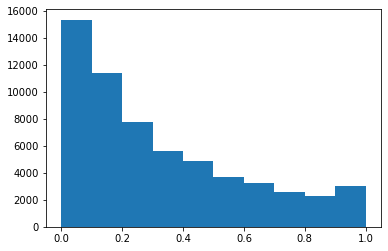

In [15]:
plt.hist(df_interintra['chi2distance']);

In [181]:
li_dist = ['chi2distance', 'DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','DTW_15_all']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualise the similarity between two individuals over time

In [28]:
df_interintra['hen_pair'] = df_interintra.apply(lambda x: '-'.join(sorted([x['henID1'],x['henID2']])), axis=1)
display(df_interintra.head(3))
df_pair = df_interintra.pivot(index='hen_pair', columns='DOA', values='chi2distance').reset_index()
print(df_pair.shape)
df_pair.head(3)

(8646, 53)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DOA,hen_pair,119,120,121,122,123,124,125,126,129,...,163,164,165,166,167,168,169,170,171,172
0,hen_1-hen_10,0.233889,0.322369,0.008576,NaN,NaN,NaN,0.004816,0.618510,0.542879,...,0.093403,0.236142,0.086732,0.214482,0.232111,0.097051,0.196894,0.307584,0.264712,0.085573
1,hen_1-hen_101,0.126262,0.412330,0.969064,NaN,NaN,NaN,0.296610,0.892051,0.913367,...,0.168710,0.084273,0.068856,0.437028,0.172978,0.138721,0.511809,0.210937,0.159825,0.062157
2,hen_1-hen_102,0.485570,0.299795,0.008576,NaN,NaN,NaN,0.181576,0.015801,0.000000,...,0.366252,0.138228,0.169119,0.129083,0.151357,0.171457,0.167181,0.257067,0.270802,0.473231


In [ ]:
#li_DOA = list(range(119,max(df_interintra['DOA'].tolist())+1))
li_DOA = list(range(119,119+20))
col_ = len(li_DOA)
lign_ = len(li_DOA)
fig = plt.figure(figsize=(3*lign_, 3*col_))
i = 1
#enumerate across x
for k1,D1 in tqdm.tqdm(enumerate(li_DOA)):
    #enumerate across y
    for k2,D2 in enumerate(li_DOA):
        
        if k2<=k1:
            plt.subplot(lign_,col_,i)
            plt.tight_layout()
            i = i+1
            plt.xticks([]) #remove xlabel annotations
            plt.yticks([])
            plt.axis('off');
        else:
            #initialize subplot
            plt.subplot(lign_,col_,i)
            plt.tight_layout()
            i = i+1
            plt.xticks([]) #remove xlabel annotations
            plt.yticks([])
            plt.axis('off');

            #data
            if (D1 in df_pair.columns) & (D2 in df_pair.columns) :
                df_ = df_pair[[D1,D2]]
                df_ = df_[~(df_.isnull().any(axis=1))]
                x = np.array(df_[D1].tolist())
                y = np.array(df_[D2].tolist())
                #if at least 10 observations
                if (len(x)>0) & (len(x)==len(y)):
                    #measures
                    Explvarscore = explained_variance_score(x, y)
                    RMSE = math.sqrt(mean_squared_error(x, y))
                    MAE = mean_absolute_error(x, y)
                    #rcoeff2, p_value2 = pearsonr(x, y)
                    rcoeff2, p_value2 = spearmanr(x, y)

                    #linear model & it's the 95% CI
                    slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model
                    #TODO: check assumption??? or not as not really using it besides visual?
                    y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
                    x_mean = np.mean(x) ; y_mean = np.mean(y)
                    n = x.size                        # number of samples
                    dof = n - 2                       # degrees of freedom: size-#parameters
                    t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
                    residual = y - y_model

                    ############### Plot
                    plt.rcParams.update({'font.size': 11})

                    #plot middle line and 95% IC
                    x_line = np.linspace(np.min(x), np.max(x), 100)
                    y_line = np.polyval([slope, intercept], x_line)
                    # confidence interval
                    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error
                    ci = t_ * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
                    plt.plot(x_line, y_line, color='black')
                    #ax.fill_between(x_line, y_line + ci, y_line - ci, alpha=0.5, color='black') #label = '95% confidence interval', 
                    plt.xlim(0,1)
                    plt.ylim(0,1)
                    #add text
                    #plt.set_xlabel(D1)
                    #plt.set_ylabel(D2)
                    #ax.text(0, max(y)-int(0.12*max(y))+epsi, 'Explained variance score = ' + str(np.round(Explvarscore,2)))
                    #ax.text(0, max(y)-int(0.24*max(y))+epsi, 'RMSE = ' + str(np.round(RMSE,2)) +\
                    #                                    '     MAE = ' + str(np.round(MAE,2)))
                    plt.text(0.03, 0.9-int(0.36*0.9), 'Pearson coef = ' + str(np.round(rcoeff2,2)))
                    plt.text(0.03, 0.8-int(0.36*0.8), 'Pearson p-value = ' + str(np.round(p_value2,3)))

                    #plot points with size equal to the amount of points (as count data)
                    # count the occurrences of each point
                    c = Counter(zip(x,y))
                    # create a list of the sizes, here multiplied by 10 for scale
                    s = [10*c[(xx,yy)] for xx,yy in zip(x,y)]
                    if p_value2<0.001:
                        plt.scatter(x, y, s=s, color='red') 
                    elif p_value2<0.01:
                        plt.scatter(x, y, s=s, color='orange') 
                    elif p_value2<0.05:
                        plt.scatter(x, y, s=s, color='yellow') 
                    elif p_value2>0.01:
                        plt.scatter(x, y, s=s, color='blue') 
                    else:
                        plt.scatter(x, y, s=s, color='green')
                    #plt.legend(bbox_to_anchor=(1, .25), fontsize=12);

                    #add diagonal line
                    #ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0)
                    plt.title('x: '+str(D1)+'  y: '+str(D2))
#save
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'HensSimilaritiesAcrosstime_'+str(col_)+'.png'), dpi=600, bbox_inches='tight')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
15it [02:02, 11.59s/it]